In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import itertools
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import roc_curve 
import numpy as np
import pandas as pd

import string
import nltk
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

from sklearn.model_selection import train_test_split
import tqdm

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


# 1. Preprocessing

In [2]:
# We define utility functions for text processing.

def removePunctuation(text):
    """
    Remove punctuation symbols and convert text to lowercase
    """
    return text.lower().translate(str.maketrans('', '', string.punctuation))

def removeStopWords(text):
    """
    Filter words that are not found in stop words
    """
    return " ".join([word for word in text.split() if word not in stopwords.words("english")])

def buildDictionary(texts):
    """
    Build the dictionary of words where key is the word and value is the index.
    """
    hashmap = {}
    for text in texts:
        for word in text.split():
            hashmap[word] = hashmap.get(word, 0) + 1
    return {w:i+1 for i, w in enumerate(list(hashmap.keys()))}

def calculateMaxSeqLen(texts):
    """
    Calculates the maximum sequence length found in the corpus
    """
    max_len = float('-inf')
    for text in texts:
        if len(text.split()) > max_len:
            max_len = len(text.split())
            
    return max_len

def lemmatize(text):
    """
    Filter words that are not found in stop words
    """
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

In [3]:
# Load the *.csv* file and filter the features that are useful for the problem:
data = pd.read_csv("../input/sms-spam-collection-dataset/spam.csv", encoding="latin-1")

In [4]:
data = data[["v2", "v1"]].rename(columns={"v2":"SMS", "v1":"target"})

In [5]:
# Text preprocessing. Remove punctuation symbols and stop words:
data["SMS"] = data["SMS"].apply(lambda x: removePunctuation(x))
data["SMS"] = data["SMS"].apply(lambda x: removeStopWords(x))
data["SMS"] = data["SMS"].apply(lambda x: lemmatize(x))

In [6]:
dictionary = buildDictionary(data["SMS"])
max_seq_len = calculateMaxSeqLen(data["SMS"])

print(f"Number of words in dictionary: {len(dictionary)}")
print(f"Maximum sequence lenght: {max_seq_len}")

Number of words in dictionary: 8902
Maximum sequence lenght: 80


In [7]:
data["target"] = data["target"].replace("ham", 0)
data["target"] = data["target"].replace("spam", 1)

In [8]:
data["target"].value_counts() / len(data)

0    0.865937
1    0.134063
Name: target, dtype: float64

In [9]:
data

,SMS,target
0,go jurong point crazy available bugis n great ...,0
1,ok lar joking wif u oni,0
2,free entry 2 wkly comp win fa cup final tkts 2...,1
3,u dun say early hor u c already say,0
4,nah dont think go usf life around though,0
...,...,...
5567,2nd time tried 2 contact u u å£750 pound prize...,1
5568,ì b going esplanade fr home,0
5569,pity mood soany suggestion,0
5570,guy bitching acted like id interested buying s...,0


In [11]:
# Split data into training and testing
x_train, x_valid, y_train, y_valid = train_test_split(data["SMS"], data["target"], test_size=0.2, stratify=data["target"])

# 2. Data loaders

In [12]:
y_valid.value_counts()

0    966
1    149
Name: target, dtype: int64

In [13]:
y_train.value_counts()

0    3859
1     598
Name: target, dtype: int64

In [14]:
BATCH_SIZE = 64
LEARNING_RATE = 0.001
DROPOUT = 0.5
INPUT_SIZE = len(dictionary) + 1
EPOCHS = 30

In [15]:
class DataHandler(Dataset):
    """
    Iterator generator for data loader construction
    """
    
    @staticmethod
    def tokenizer(X, max_seq_len, dicitionary):
        """
        Given a sequence of words, tokenize each word with 
        use of `dictionary` and apply padding considering `max_seq_len`
        """
        sequences = []
        for x in X:
            sequence = [0] * max_seq_len
            for idx, word in enumerate(x.split()):
                sequence[idx] = dictionary[word]
            sequences.append(sequence)
            
        return np.array(sequences)
    
    def __init__(self, x, y, max_seq_len, dictionary):
        self.x = self.tokenizer(x, max_seq_len, dictionary)
        self.y = y.to_numpy()
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [16]:
# Initialize iterator objects for the data loader
train = DataHandler(x_train, y_train, max_seq_len, dictionary)
valid = DataHandler(x_valid, y_valid, max_seq_len, dictionary)

In [17]:
# Initialize data loaders
loader_training = DataLoader(train, batch_size=BATCH_SIZE, shuffle=False)
loader_valid = DataLoader(valid, batch_size=BATCH_SIZE, shuffle=False)

In [18]:
txt1 = iter(loader_valid)

In [19]:
x, y = next(txt1)

In [21]:
x_valid.reset_index()["SMS"].loc[0].split() 

['urgent',
 'mobile',
 'number',
 'awarded',
 'å£2000',
 'prize',
 'guaranteed',
 'call',
 '09058094454',
 'land',
 'line',
 'claim',
 '3030',
 'valid',
 '12hrs']

In [22]:
for word in x_valid.reset_index()["SMS"].loc[0].split() :
    print(dictionary[word])

154
112
760
493
752
102
601
105
6151
1763
1484
104
1764
109
697


In [23]:
x[0]

tensor([ 154,  112,  760,  493,  752,  102,  601,  105, 6151, 1763, 1484,  104,
        1764,  109,  697,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [24]:
y_valid.reset_index()["target"].loc[0]

1

In [25]:
y[0].item()

1

# 3. Model

In [26]:
x.shape, len(y)

(torch.Size([64, 80]), 64)

In [33]:
EMBEDDING_DIM = 512
HIDDEN_DIM = 512
LSTM_LAYERS = 2

class TextClassifier(nn.ModuleList):
    """
    LSTM Network definition
    """
    def __init__(self):
        super(TextClassifier, self).__init__()

        self.batch_size = BATCH_SIZE
        self.embedding_dim = EMBEDDING_DIM
        self.hidden_dim = HIDDEN_DIM
        self.LSTM_layers = LSTM_LAYERS
        self.input_size = INPUT_SIZE
        self.max_seq_len = max_seq_len

        self.dropout = nn.Dropout(DROPOUT)
        self.embedding = nn.Embedding(num_embeddings=self.input_size, embedding_dim=self.embedding_dim, padding_idx=0)
        
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.hidden_dim, dropout=DROPOUT,
                            num_layers=self.LSTM_layers, batch_first=True, bidirectional=True)
        self.maxpool1d = nn.MaxPool1d(kernel_size=3)
#         self.fc1 = nn.Linear(in_features=self.hidden_dim*4, out_features=512)
        self.fc1 = nn.Linear(682, out_features=512)
        self.fc2 = nn.Linear(512, 1)
        self.sigmoid = nn.Sigmoid()

    

    def forward(self, x):        
        embedded = self.embedding(x)

        out, (hidden, cell) = self.lstm(embedded)

        concat_hidden = torch.cat((hidden[0], hidden[1]), dim=1)
        concat_cell = torch.cat((cell[0], cell[1]), dim=1)
        all_states = torch.cat((concat_hidden, concat_cell), dim=1)
        maxpooled = self.maxpool1d(all_states)
        out = torch.relu_(self.fc1(maxpooled))
        out = self.dropout(out)
        out = self.sigmoid(self.fc2(out))
        return out.squeeze() 

# Identify device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model initialization
model = TextClassifier().to(device)
print(model)

TextClassifier(
  (dropout): Dropout(p=0.5, inplace=False)
  (embedding): Embedding(8903, 512, padding_idx=0)
  (lstm): LSTM(512, 512, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (maxpool1d): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=682, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [34]:
x.shape

torch.Size([64, 80])

In [35]:
y.shape

torch.Size([64])

In [36]:
model(x.cuda()).shape

torch.Size([64])

In [37]:
# Optimizer initialization
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCELoss()

In [38]:
def calculate_accuracy_with_selected_threshold(grand_truth, predictions):
    """
    Accuracy calcuation: (tp + tn) / N
    """
    true_positives, true_negatives = 0, 0
    fpr, tpr, thr = roc_curve(grand_truth, predictions)
    roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thr':thr});
    roc['random'] = roc['fpr'].copy()
    roc['diff'] = roc['tpr'] - roc['fpr']
    roc = roc.sort_values('diff', ascending=False).reset_index().drop('index', axis=1)
    
    for true, pred in zip(grand_truth, predictions):
        if (pred > roc.loc[0,'thr']) and (true == 1):
            true_positives += 1
        elif (pred < roc.loc[0,'thr']) and (true == 0):
            true_negatives += 1
    threshold = roc.loc[0,'thr']
    return ((true_positives+true_negatives) / len(grand_truth)), threshold

def calculate_accuray_with_point_five(grand_truth, predictions):
    """
    Accuracy calcuation: (tp + tn) / N
    """
    true_positives, true_negatives = 0, 0    
    for true, pred in zip(grand_truth, predictions):
        if (pred > 0.5) and (true == 1):
            true_positives += 1
        elif (pred < 0.5) and (true == 0):
            true_negatives += 1
    return (true_positives+true_negatives) / len(grand_truth)

In [39]:
# Training
EPOCHS = 15
valid_accuracy_min = 0
for epoch in range(EPOCHS):
    model.train()
    train_predictions = []
    for x_batch, y_batch in tqdm.tqdm(loader_training, desc=f"training epoch {epoch+1}"):
        
        x = x_batch.type(torch.LongTensor).to(device)
        y = y_batch.type(torch.FloatTensor).to(device)
        
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        
        #gradient clipping to prevent exploding gradients
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
        
        optimizer.step()
        
        # Save predictions for metrics calculation
        train_predictions += list(y_pred.squeeze().cpu().detach().numpy())
    
    # Evaluation
    with torch.no_grad():
        model.eval()
        valid_predictions = []
        for x_batch, y_batch in tqdm.tqdm(loader_valid, desc=f"validation epoch {epoch+1}"):
            x = x_batch.type(torch.LongTensor).to(device)
            y = y_batch.type(torch.FloatTensor).to(device)
            
            y_pred = model(x)
            # Save predictions for metrics calculation
            valid_predictions += list(y_pred.squeeze().cpu().detach().numpy())

    train_accuracy = calculate_accuracy_with_selected_threshold(y_train, train_predictions)[0]
    valid_accuracy = calculate_accuracy_with_selected_threshold(y_valid, valid_predictions)[0]
    print(f"epoch: {epoch+1}, loss: {loss.item():.5f}, train: {train_accuracy:.5f}, valid: {valid_accuracy:.5f}")
    if valid_accuracy >= valid_accuracy_min:
        print('Valid metrics improved ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_accuracy_min,valid_accuracy))
        # change the name, for saving multiple files
        torch.save(model.state_dict(), 'text_clf.pt')
        valid_accuracy_min = valid_accuracy
        print("=========================================")

validation epoch 1: 100%|██████████| 18/18 [00:00<00:00, 32.97it/s]


epoch: 1, loss: 0.08314, train: 0.84451, valid: 0.96592
Valid metrics improved (0.000000 --> 0.965919).  Saving model ...


validation epoch 2: 100%|██████████| 18/18 [00:00<00:00, 32.67it/s]


epoch: 2, loss: 0.00670, train: 0.97734, valid: 0.96951
Valid metrics improved (0.965919 --> 0.969507).  Saving model ...


validation epoch 3: 100%|██████████| 18/18 [00:00<00:00, 32.88it/s]


epoch: 3, loss: 0.00397, train: 0.99753, valid: 0.95067


validation epoch 4: 100%|██████████| 18/18 [00:00<00:00, 32.20it/s]


epoch: 4, loss: 0.00049, train: 0.99619, valid: 0.97040
Valid metrics improved (0.969507 --> 0.970404).  Saving model ...


validation epoch 5: 100%|██████████| 18/18 [00:00<00:00, 32.11it/s]


epoch: 5, loss: 0.00099, train: 0.99506, valid: 0.96861


validation epoch 6: 100%|██████████| 18/18 [00:00<00:00, 31.68it/s]


epoch: 6, loss: 0.00263, train: 0.99910, valid: 0.97758
Valid metrics improved (0.970404 --> 0.977578).  Saving model ...


validation epoch 7: 100%|██████████| 18/18 [00:00<00:00, 31.21it/s]


epoch: 7, loss: 0.00001, train: 0.99978, valid: 0.98027
Valid metrics improved (0.977578 --> 0.980269).  Saving model ...


validation epoch 8: 100%|██████████| 18/18 [00:00<00:00, 30.56it/s]


epoch: 8, loss: 0.00000, train: 0.99978, valid: 0.98027
Valid metrics improved (0.980269 --> 0.980269).  Saving model ...


validation epoch 9: 100%|██████████| 18/18 [00:00<00:00, 30.35it/s]


epoch: 9, loss: 0.00000, train: 0.99978, valid: 0.98027
Valid metrics improved (0.980269 --> 0.980269).  Saving model ...


validation epoch 10: 100%|██████████| 18/18 [00:00<00:00, 30.02it/s]


epoch: 10, loss: 0.00000, train: 0.99978, valid: 0.98027
Valid metrics improved (0.980269 --> 0.980269).  Saving model ...


validation epoch 11: 100%|██████████| 18/18 [00:00<00:00, 29.66it/s]


epoch: 11, loss: 0.00000, train: 0.99978, valid: 0.98027
Valid metrics improved (0.980269 --> 0.980269).  Saving model ...


validation epoch 12: 100%|██████████| 18/18 [00:00<00:00, 29.04it/s]


epoch: 12, loss: 0.00000, train: 0.99978, valid: 0.98027
Valid metrics improved (0.980269 --> 0.980269).  Saving model ...


validation epoch 13: 100%|██████████| 18/18 [00:00<00:00, 28.86it/s]


epoch: 13, loss: 0.00000, train: 0.99978, valid: 0.98027
Valid metrics improved (0.980269 --> 0.980269).  Saving model ...


training epoch 14:  63%|██████▎   | 44/70 [00:04<00:02,  8.91it/s]


KeyboardInterrupt: 

In [40]:
model.load_state_dict(torch.load('text_clf.pt'))

<All keys matched successfully>

In [41]:
from sklearn.metrics import confusion_matrix
with torch.no_grad():
    model.eval()
    valid_predictions = []
    y_true = []
    for x_batch, y_batch in loader_valid:
        x = x_batch.type(torch.LongTensor).to(device)
        y = y_batch.type(torch.FloatTensor).to(device)

        y_pred = model(x)
        # Save predictions for metrics calculation
        y_true += list(y.squeeze().cpu().detach().numpy())
        valid_predictions += list(y_pred.squeeze().cpu().detach().numpy())
        
    valid_accuracy, threhold = calculate_accuracy_with_selected_threshold(y_valid, valid_predictions)
    print(f"valid accuracy: {valid_accuracy:.5f}, threshold {threhold}")

valid accuracy: 0.98027, threshold 0.4903941750526428


In [42]:
predictions = (np.array(valid_predictions) > threhold).astype('int64').tolist()
confusion_matrix(y_true, predictions)

array([[957,   9],
       [ 13, 136]])

<AxesSubplot:xlabel='fpr'>

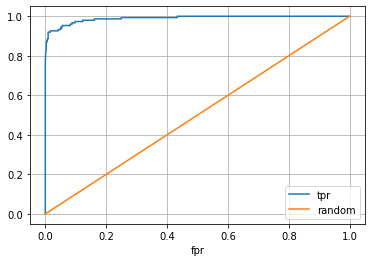

In [43]:
fpr, tpr, thr = roc_curve(y_valid, valid_predictions)
roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thr':thr});
roc['random'] = roc['fpr'].copy()
roc['diff'] = roc['tpr'] - roc['fpr']
roc.plot(x='fpr', y=['tpr','random'], figsize=(6,4), grid=True)

In [44]:
roc = roc.sort_values('diff', ascending=False).reset_index().drop('index', axis=1)

In [45]:
roc

,fpr,tpr,thr,random,diff
0,0.009317,0.919463,4.903942e-01,0.009317,0.910146
1,0.016563,0.926174,7.637864e-03,0.016563,0.909611
2,0.016563,0.919463,1.184588e-02,0.016563,0.902900
3,0.055901,0.953020,3.719751e-06,0.055901,0.897120
4,0.052795,0.946309,4.631085e-06,0.052795,0.893514
...,...,...,...,...,...
75,0.873706,1.000000,1.870707e-11,0.873706,0.126294
76,0.901656,1.000000,1.123479e-11,0.901656,0.098344
77,0.903727,1.000000,1.106566e-11,0.903727,0.096273
78,0.000000,0.000000,2.000000e+00,0.000000,0.000000
